In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

## GOTerm

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from scipy.spatial.distance import cosine

# Load the SapBERT model and tokenizer
model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Get the embeddings from the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the mean of the last hidden state as the sentence embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings

def calculate_similarity(text1, text2):
    # Get embeddings for both texts
    embedding1 = get_embeddings(text1)
    embedding2 = get_embeddings(text2)
    
    # Calculate cosine similarity (1 - cosine distance)
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

/opt/anaconda3/envs/llms/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
res = pd.read_csv('/Users/linxy29/Documents/Data/GeneRAG/benchmark/GOTerm/combined_results.csv')
res.head()

,question,answer,reasoning,confidence,time_taken,error,model,id,GO terms,go_terms,genes,additional_details,GO_terms
0,\n You are given a list of genes. Y...,Argininosuccinate synthase activity(0.85),NaN,0.85,4.275,NaN,deepseek-chat,GO:0000053,NaN,NaN,NaN,NaN,NaN
1,\n You are given a list of genes. Y...,"argininosuccinate synthase activity, urea cycl...","Okay, let's tackle this question. The user pro...",0.85,58.766,NaN,deepseek-reasoner,GO:0000053,NaN,NaN,NaN,NaN,NaN
2,\n You are given a list of genes. Y...,"['argininosuccinate synthase activity', 'urea ...",ASS1 encodes the enzyme argininosuccinate synt...,0.85,1.882,NaN,gpt-4o,GO:0000053,NaN,NaN,NaN,NaN,NaN
3,\n You are given a list of genes. Y...,Argininosuccinate synthase,The gene 'ASS1' is associated with the GO term...,0.988,4.355,NaN,meta-llama/Meta-Llama-3.1-405B-Instruct,GO:0000053,NaN,NaN,NaN,NaN,NaN
4,\n You are given a list of genes. Y...,Nitrogen compound metabolic process,The gene ASS1 (argininosuccinate synthase 1) i...,0.85,5.368,NaN,Qwen/Qwen2.5-72B-Instruct,GO:0000053,NaN,NaN,NaN,NaN,NaN


In [4]:
file_path = "/Users/linxy29/Documents/Data/GeneRAG/benchmark/GOTerm/go_terms_and_genes.csv"
input_df = pd.read_csv(file_path)
input_df.head()

,GO_ID,GO_Name,GO_Namespace,GO_Definition,Genes
0,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...","['OPA1', 'SLC25A4', 'TYMP', 'LONP1', 'MPV17', ..."
1,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...","['PIGV', 'ALG12']"
2,GO:0000012,single strand break repair,biological_process,"""The repair of single strand breaks in DNA. Re...","['TNP1', 'UNG', 'XRCC1', 'LIG4', 'ERCC6', 'ERC..."
3,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,molecular_function,"""Catalysis of the hydrolysis of ester linkages...","['ERCC1', 'MRE11', 'ASTE1', 'SETMAR', 'RAD50',..."
4,GO:0000015,phosphopyruvate hydratase complex,cellular_component,"""A multimeric enzyme complex, usually a dimer ...","['ENO1', 'ENO4', 'ENO3', 'ENO2']"


In [5]:
input_df['id'] = input_df['GO_ID']
res = res.merge(input_df[['id', 'GO_Name', 'GO_Namespace']], on='id', how='left')
print(res.head())

                                            question  \
0  \n            You are given a list of genes. Y...   
1  \n            You are given a list of genes. Y...   
2  \n            You are given a list of genes. Y...   
3  \n            You are given a list of genes. Y...   
4  \n            You are given a list of genes. Y...   

                                              answer  \
0          Argininosuccinate synthase activity(0.85)   
1  argininosuccinate synthase activity, urea cycl...   
2  ['argininosuccinate synthase activity', 'urea ...   
3                         Argininosuccinate synthase   
4                Nitrogen compound metabolic process   

                                           reasoning confidence  time_taken  \
0                                                NaN       0.85       4.275   
1  Okay, let's tackle this question. The user pro...       0.85      58.766   
2  ASS1 encodes the enzyme argininosuccinate synt...       0.85       1.882   
3  The gen

In [6]:
## filter Na file
res = res[res['answer'].notna()]
res['group'] = np.random.randint(1, 11, size=len(res))

# -------------------------------------------
# 1) Calculate score for each group, model and Namespace
# -------------------------------------------
res['score'] = res.apply(lambda row: calculate_similarity(row['answer'], row['GO_Name']), axis=1)
res.to_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/GOTerm/combined_results_evaluation.csv")

In [7]:
res = pd.read_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/GOTerm/combined_results_evaluation.csv")

In [8]:
res['model'] = res['model'].replace({
    'Qwen/Qwen2.5-72B-Instruct': 'Qwen2.5-72B',  
    'deepseek-ai/DeepSeek-R1-Distill-Llama-8B': 'Distill-Llama-8B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': 'Distill-Qwen-7B',  
    'deepseek-chat': 'DeepSeek-V3',
    'deepseek-reasoner': 'DeepSeek-R1',  
    'meta-llama/Meta-Llama-3.1-405B-Instruct': 'Llama-3.1-405B',
    'gpt-4o': 'GPT-4o'
})

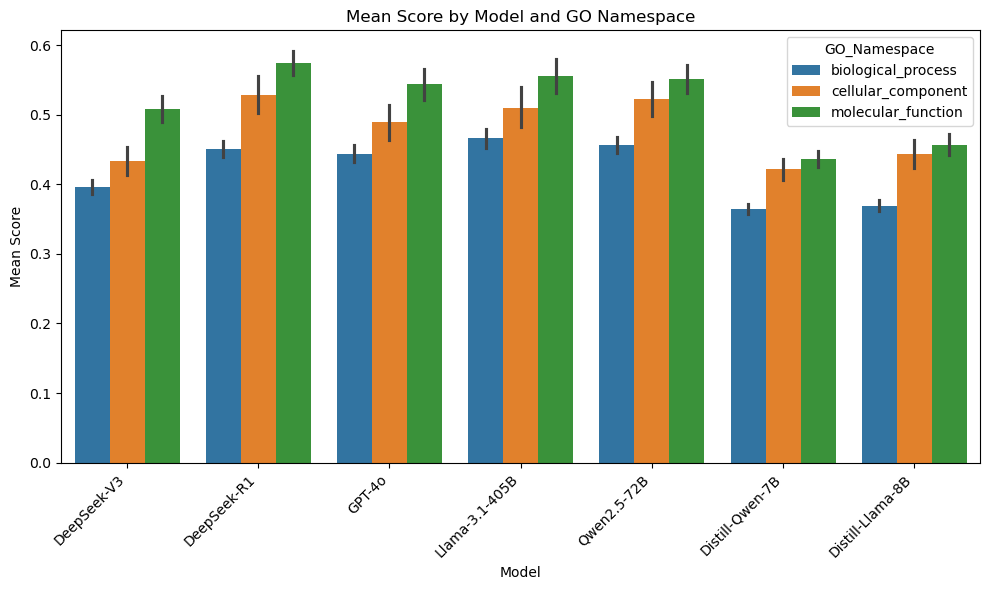

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=res,
    x="model",
    y="score",
    hue="GO_Namespace",
    estimator=np.mean,
    errorbar=("ci", 95)  # This adds error bars representing 95% confidence intervals
)

plt.xlabel("Model")
plt.ylabel("Mean Score")
plt.title("Mean Score by Model and GO Namespace")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [11]:
grouped_stats = res.groupby(['model', 'GO_Namespace'])['score'].agg(
    mean_score='mean',
    variance_score='var'
).reset_index()
grouped_stats.round(3).to_csv('/Users/linxy29/Documents/Data/GeneRAG/benchmark/GOTerm/grouped.csv')

In [12]:
print(grouped_stats)

               model        GO_Namespace  mean_score  variance_score
0        DeepSeek-R1  biological_process    0.450459        0.022027
1        DeepSeek-R1  cellular_component    0.528100        0.024364
2        DeepSeek-R1  molecular_function    0.573591        0.017477
3        DeepSeek-V3  biological_process    0.396157        0.016306
4        DeepSeek-V3  cellular_component    0.433365        0.015339
5        DeepSeek-V3  molecular_function    0.507723        0.019587
6   Distill-Llama-8B  biological_process    0.368701        0.009778
7   Distill-Llama-8B  cellular_component    0.443769        0.012531
8   Distill-Llama-8B  molecular_function    0.456312        0.012396
9    Distill-Qwen-7B  biological_process    0.364608        0.008676
10   Distill-Qwen-7B  cellular_component    0.421297        0.007776
11   Distill-Qwen-7B  molecular_function    0.436735        0.006735
12            GPT-4o  biological_process    0.443272        0.024343
13            GPT-4o  cellular_com

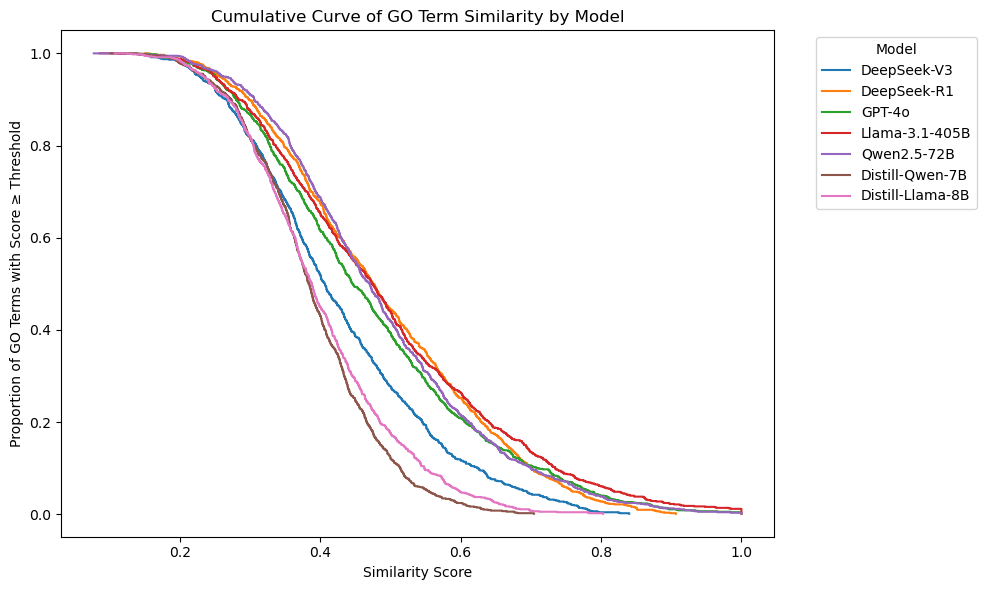

In [13]:
n = len(res['id'].unique())
counts = n - np.arange(n)
proportions = (n - np.arange(n)) / n
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10, 6))

# Create a color palette with one colour per model
models = res['model'].unique()
palette = sns.color_palette("tab10", n_colors=len(models))

# Loop over each unique model and plot its cumulative curve
for i, model in enumerate(models):
    # Filter for the current model
    subset = res[res['model'] == model]
    # Sort the similarity scores
    scores = np.sort(subset['score'].values)
    n = len(scores)
    # For each threshold, compute the proportion of GO Terms with a score ≥ threshold
    proportions = (n - np.arange(n)) / n
    # Plot the step curve with the designated color
    plt.step(scores, proportions, where="post", label=model, color=palette[i])

plt.xlabel("Similarity Score")
plt.ylabel("Proportion of GO Terms with Score ≥ Threshold")
plt.title("Cumulative Curve of GO Term Similarity by Model")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Use of Evidence: Prefer models that cite evidence or known associations for each GO term (e.g., “Gene X is involved in glycolysis (GO:0006096) according to GO annotations”). 

## Recall (Quantitative): 
Compute recall – the fraction of known relevant GO terms that the model successfully predicted. For example, if there are 10 GO terms commonly associated with these genes and the model lists 7 of them, recall = 0.7 (70%). High recall means the model captured most of the relevant terms​
PMC.NCBI.NLM.NIH.GOV. It’s useful to calculate recall separately for MF, BP, and CC to ensure the model isn’t overlooking an entire GO aspect.

Knowledge-Based Inference: Determine if the model is leveraging established knowledge bases or factual recall. A knowledge-based approach might directly recall GO annotations or known gene functions (e.g., “Gene B is a transcription factor (GO:0003700) as annotated in UniProt”). Models using this approach may map genes to GO terms through stored facts or ontology structure. This often results in direct gene→GO term mappings and indicates the model relies on built-in knowledge.

Literature-Based Reasoning: Check if the model infers GO terms by synthesizing information akin to reading literature. For instance, the model might note “Gene C is frequently mentioned in papers about cell cycle regulation, suggesting involvement in the cell cycle process (GO:0007049)”. This implies the model is drawing on context from scientific literature or general language training data, rather than an explicit GO mapping. It may follow a gene→context (pathway/phenotype)→GO term route.

/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_68583/282478321.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_stats = res.groupby(['model', 'time_level'])['score'].agg(['mean', 'var']).reset_index()


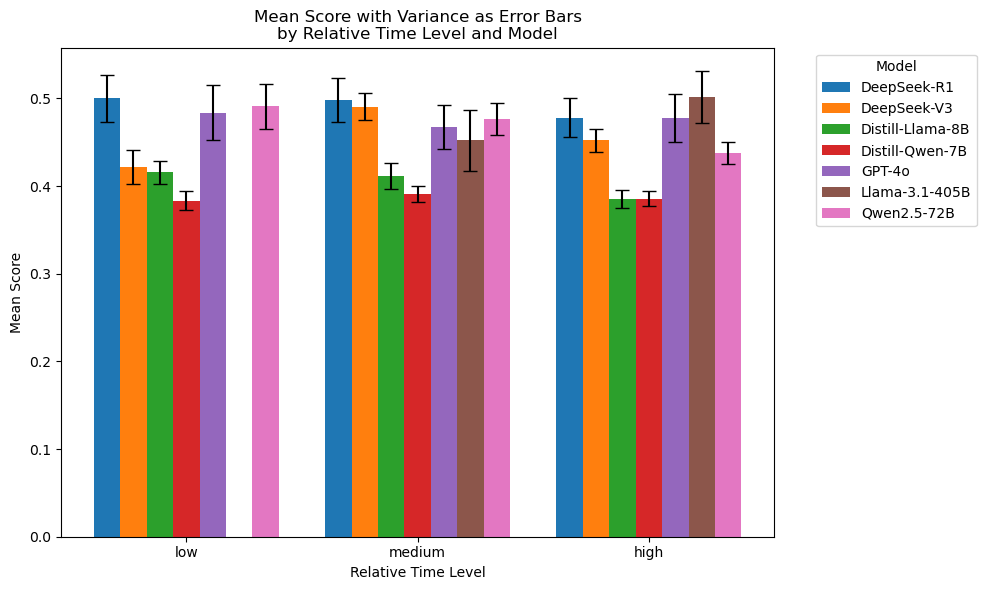

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Compute relative time and split into three groups ---
# Normalize time_taken by the maximum time_taken within each model
res['rel_time'] = res['time_taken'] / res.groupby('model')['time_taken'].transform('max')

# Use pd.qcut to split the relative time into three groups
res['time_level'] = pd.qcut(res['rel_time'], q=3, labels=['low', 'medium', 'high'])

# --- Step 2: Compute mean and variance of scores per model and time_level ---
score_stats = res.groupby(['model', 'time_level'])['score'].agg(['mean', 'var']).reset_index()

# Pivot the table so that x-axis (time_level) becomes the index and models are the columns
mean_pivot = score_stats.pivot(index='time_level', columns='model', values='mean')
var_pivot = score_stats.pivot(index='time_level', columns='model', values='var')

# --- Step 3: Create a grouped bar plot with error bars for variance ---
models = mean_pivot.columns.tolist()         # list of models (for grouping)
time_levels = mean_pivot.index.tolist()        # ['low', 'medium', 'high']
n_levels = len(time_levels)
n_models = len(models)
x = np.arange(n_levels)                        # label locations
width = 0.8 / n_models                         # width of each bar

plt.figure(figsize=(10,6))

# For each model, plot the mean score with error bar representing the variance
for i, model in enumerate(models):
    means = mean_pivot[model]
    errors = var_pivot[model]  # using variance as the error bar value
    plt.bar(x + i*width, means, width, yerr=errors, capsize=5, label=model)

plt.xlabel("Relative Time Level")
plt.ylabel("Mean Score")
plt.title("Mean Score with Variance as Error Bars\nby Relative Time Level and Model")
plt.xticks(x + width*(n_models-1)/2, time_levels)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/Users/linxy29/Documents/Files/other collaboration/benchmark/supplementary figure/Supplementary Figure t3 time vs score.pdf')
plt.show()


In [15]:
import pandas as pd
import ast
import re

# 定义提取基因列表的函数
def extract_gene_list(text):
    # 使用正则表达式匹配基因列表部分
    match = re.search(r"Genes:\s*(\[.*?\])", text)
    if match:
        try:
            # 将字符串转换为列表对象
            return ast.literal_eval(match.group(1))
        except:
            return []
    return []

# 应用函数创建新列
res['gene_list'] = res['question'].apply(extract_gene_list)

# 计算列表长度
res['gene_count'] = res['gene_list'].apply(len)

# 验证前5条结果
print(res[['question', 'gene_list', 'gene_count']].tail())

                                               question       gene_list  \
6570  \n            You are given a list of genes. Y...  [ARL6IP5, TNF]   
6571  \n            You are given a list of genes. Y...  [ARL6IP5, TNF]   
6572  \n            You are given a list of genes. Y...  [ARL6IP5, TNF]   
6573  \n            You are given a list of genes. Y...  [ARL6IP5, TNF]   
6574  \n            You are given a list of genes. Y...  [ARL6IP5, TNF]   

      gene_count  
6570           2  
6571           2  
6572           2  
6573           2  
6574           2  


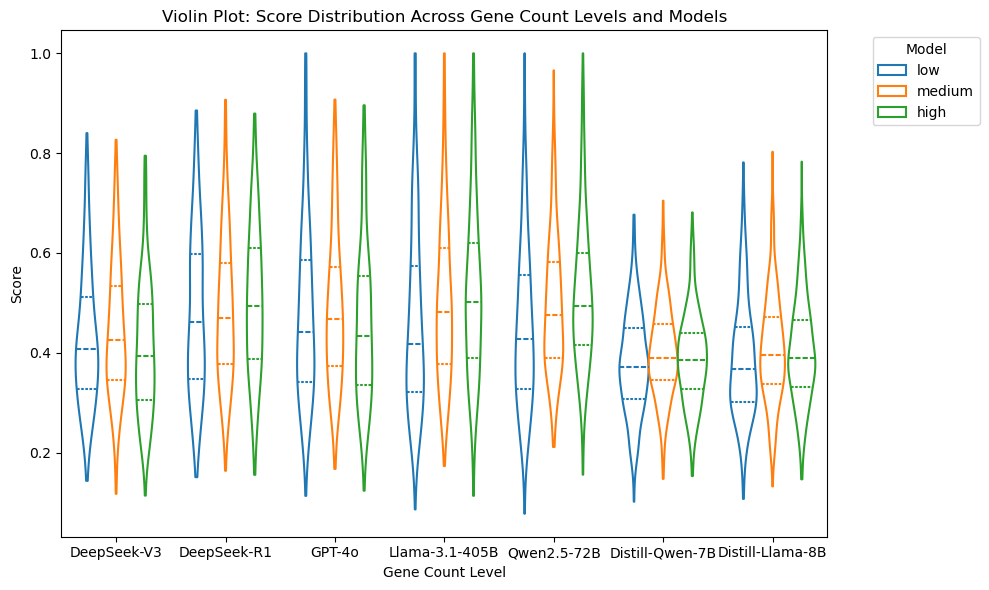

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create gene_count_level from gene_count using quantile-based discretization
res['gene_count_level'] = pd.qcut(res['gene_count'], q=3, labels=['low', 'medium', 'high'])

plt.figure(figsize=(10,6))
sns.violinplot(x='model', y='score', hue='gene_count_level', data=res, inner='quartile', fill=False,
               cut=0)

plt.xlabel("Gene Count Level")
plt.ylabel("Score")
plt.title("Violin Plot: Score Distribution Across Gene Count Levels and Models")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  
plt.savefig('/Users/linxy29/Documents/Files/other collaboration/benchmark/supplementary figure/Supplementary Figure t3 gene count vs score.pdf')
plt.show()


### Reasoning

In [17]:
import pandas as pd
import re

res_reasoning = res[res['reasoning'].notna()]

# Define keyword lists for each reasoning type
knowledge_keywords = [
    "UniProt",      # Explicit database reference
    "GO:",          # Presence of GO term ID
    "annotation",   # Direct annotation reference
    "I know",       # Indicates fact recall
    "documented in",# Another explicit reference cue
    "fact",         # Implies factual recall
    "direct mapping"
]

literature_keywords = [
    "studies suggest",     # Suggestive of literature evidence
    "papers",              # Indicates reference to literature
    "literature",          # General mention of research literature
    "research",            # General research context
    "frequently mentioned",# Indicates frequency in publications
    "implies",             # Inferential language
    "suggests",            # Inferential language
    "reported",            # Reporting of findings
    "observed",            # Based on experimental observation
    "evidence"             # Reference to supporting evidence
]

def classify_reasoning(text):
    """
    Classify reasoning text based on the occurrence of knowledge-based
    and literature-based keywords.
    """
    text_lower = text.lower()
    kbi_score = 0
    lbr_score = 0
    
    # Count matches for knowledge-based keywords
    for keyword in knowledge_keywords:
        # Use a case-insensitive search
        if re.search(re.escape(keyword.lower()), text_lower):
            kbi_score += 1

    # Count matches for literature-based keywords
    for keyword in literature_keywords:
        if re.search(re.escape(keyword.lower()), text_lower):
            lbr_score += 1

    # Classification based on scores
    if kbi_score > lbr_score:
        return "Knowledge-Based"
    elif lbr_score > kbi_score:
        return "Literature-Based"
    elif kbi_score == lbr_score and kbi_score > 0:
        return "Mixed"
    else:
        return "Not Classified"

# Apply the classification to each row in the 'reasoning' column
res_reasoning['reasoning_type'] = res_reasoning['reasoning'].apply(classify_reasoning)

# Show the DataFrame with the new classification column
print(res_reasoning.head())


   Unnamed: 0                                           question  \
1           1  \n            You are given a list of genes. Y...   
2           2  \n            You are given a list of genes. Y...   
3           3  \n            You are given a list of genes. Y...   
4           4  \n            You are given a list of genes. Y...   
8           8  \n            You are given a list of genes. Y...   

                                              answer  \
1  argininosuccinate synthase activity, urea cycl...   
2  ['argininosuccinate synthase activity', 'urea ...   
3                         Argininosuccinate synthase   
4                Nitrogen compound metabolic process   
8           ribosomal small subunit biogenesis(0.85)   

                                           reasoning confidence  time_taken  \
1  Okay, let's tackle this question. The user pro...       0.85      58.766   
2  ASS1 encodes the enzyme argininosuccinate synt...       0.85       1.882   
3  The gene 'ASS1

/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_68583/2723082558.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_reasoning['reasoning_type'] = res_reasoning['reasoning'].apply(classify_reasoning)


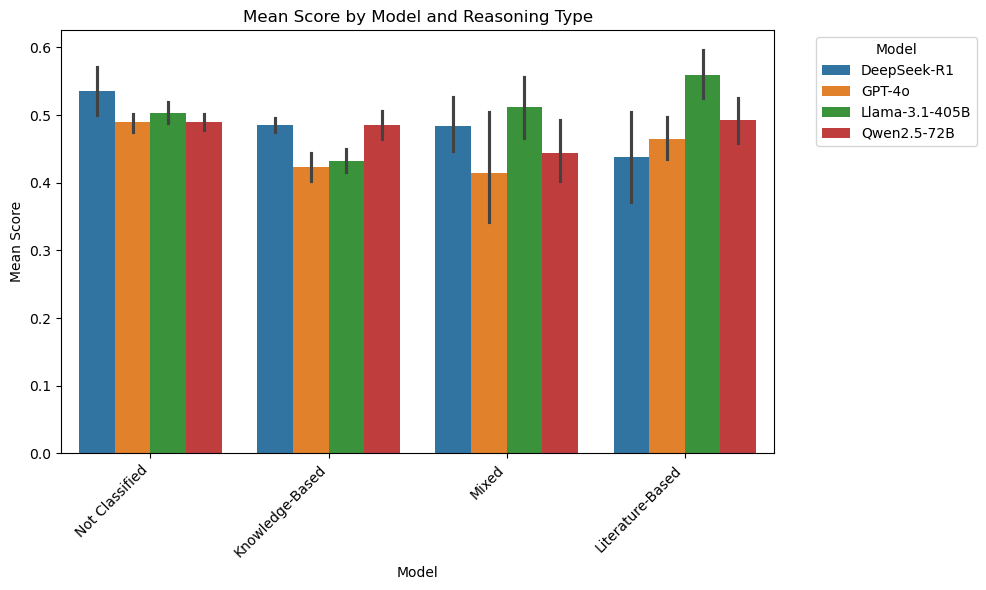

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=res_reasoning,
    x="reasoning_type",
    y="score",
    hue="model",
    estimator=np.mean,
    errorbar=("ci", 95)  # This adds error bars representing 95% confidence intervals
)

plt.xlabel("Model")
plt.ylabel("Mean Score")
plt.title("Mean Score by Model and Reasoning Type")
plt.xticks(rotation=45, ha="right")
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/Users/linxy29/Documents/Files/other collaboration/benchmark/supplementary figure/Supplementary Figure t3 reasoning type vs score.pdf')
plt.show()

/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_68583/3502999240.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_reasoning['reasoning_type'] = res_reasoning['reasoning_type'].str.strip()


<Figure size 1000x600 with 0 Axes>

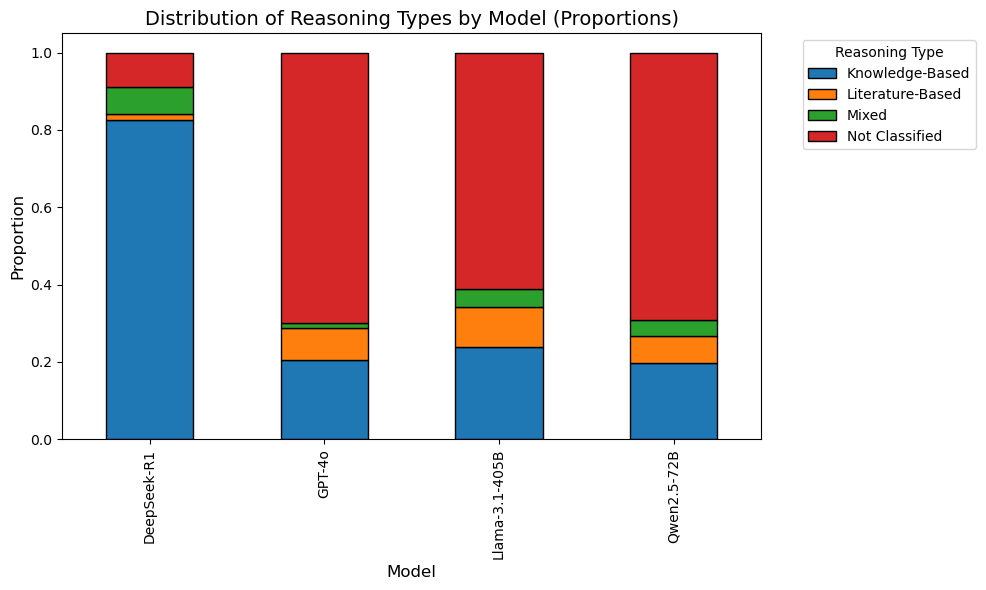

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is 'res'
# Clean any whitespace in reasoning_type
res_reasoning['reasoning_type'] = res_reasoning['reasoning_type'].str.strip()

# Aggregate counts per model and reasoning_type
counts = res_reasoning.groupby(['model', 'reasoning_type']).size().unstack(fill_value=0)

# Convert counts to proportions (each row sums to 1)
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot a stacked bar chart of proportions using Pandas plotting
plt.figure(figsize=(10, 6))
ax = proportions.plot(kind='bar', stacked=True, edgecolor='black', figsize=(10, 6))

plt.title('Distribution of Reasoning Types by Model (Proportions)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Reasoning Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Reasoning analysis

In [15]:
import pandas as pd
import textstat
import nltk
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# Download NLTK's punkt tokenizer if not already downloaded
nltk.download('punkt_tab')

# ----------------------------
# 1. Readability Analysis
# ----------------------------
def readability_analysis(text):
    """
    Compute readability metrics for the given text and return them as a dictionary.
    """
    metrics = {
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
        "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
        "smog_index": textstat.smog_index(text)
    }
    return metrics

# ----------------------------
# 2. Textual Entailment Analysis
# ----------------------------
# Initialize the entailment pipeline using the roberta-large-mnli model.
nli_pipeline = pipeline("text-classification", model="roberta-large-mnli", return_all_scores=True)

def check_entailment(premise, hypothesis):
    """
    Check entailment between a premise and a hypothesis.
    Returns the entailment score (between 0 and 1), where a higher score suggests a stronger logical connection.
    """
    text_input = f"{premise} [SEP] {hypothesis}"
    results = nli_pipeline(text_input)
    # results is a list with one element: a list of dictionaries (one for each label)
    entailment_score = None
    for result in results[0]:
        if result['label'] == 'ENTAILMENT':
            entailment_score = result['score']
            break
    return entailment_score

# ----------------------------
# 3. Semantic Coherence and Similarity
# ----------------------------
# Load a SentenceTransformer model for embedding sentences.
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_semantic_similarity(sentences):
    """
    Compute cosine similarity between consecutive sentences in a list.
    Returns a list of similarity scores.
    """
    embeddings = sbert_model.encode(sentences, convert_to_tensor=True)
    similarities = []
    for i in range(len(sentences) - 1):
        sim = util.cos_sim(embeddings[i], embeddings[i+1])
        similarities.append(sim.item())
    return similarities

# ----------------------------
# 4. Combine Analysis for Each Reasoning Content
# ----------------------------
def analyze_reasoning(text):
    """
    For a given reasoning text, compute readability metrics,
    average textual entailment score between consecutive sentences, 
    and average semantic similarity between consecutive sentences.
    Returns a dictionary of metrics.
    """
    # Compute readability metrics
    readability = readability_analysis(text)
    
    # Sentence segmentation using NLTK
    sentences = nltk.sent_tokenize(text)
    
    # Compute entailment scores between consecutive sentences
    entailment_scores = []
    if len(sentences) > 1:
        for i in range(len(sentences) - 1):
            score = check_entailment(sentences[i], sentences[i+1])
            if score is not None:
                entailment_scores.append(score)
    avg_entailment = sum(entailment_scores) / len(entailment_scores) if entailment_scores else None
    
    # Compute semantic similarity scores between consecutive sentences
    semantic_similarities = compute_semantic_similarity(sentences) if len(sentences) > 1 else []
    avg_semantic_similarity = sum(semantic_similarities) / len(semantic_similarities) if semantic_similarities else None
    
    return {
        "flesch_reading_ease": readability["flesch_reading_ease"],
        "flesch_kincaid_grade": readability["flesch_kincaid_grade"],
        "smog_index": readability["smog_index"],
        "avg_entailment": avg_entailment,
        "avg_semantic_similarity": avg_semantic_similarity,
        "num_sentences": len(sentences)
    }

# ----------------------------
# 5. Apply Analysis to the DataFrame
# ----------------------------
# Assuming your DataFrame 'res' has a column named 'reasoning'
# We apply the analyze_reasoning function to each reasoning text and expand the results into new columns.
res_reasoning = res[res['reasoning'].notna()]
metrics_df = res_reasoning['reasoning'].apply(lambda x: pd.Series(analyze_reasoning(x)))

# Optionally, you can merge these new metrics back into your original DataFrame:
res_reasoning = pd.concat([res_reasoning, metrics_df], axis=1)

/opt/anaconda3/envs/llms/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/linxy29/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initiali

In [3]:
#res_reasoning.to_csv('/Users/linxy29/Documents/Data/GeneRAG/benchmark/GOTerm/combined_results_evaluation_reasoning.csv')
res_reasoning = pd.read_csv('/Users/linxy29/Documents/Data/GeneRAG/benchmark/GOTerm/combined_results_evaluation_reasoning.csv')

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'res' is your DataFrame.
# 1. Normalize the 'flesch_reading_ease' column by dividing by its maximum.
max_reading = res_reasoning['flesch_reading_ease'].max()
res_reasoning['normalized_flesch_reading_ease'] = res_reasoning['flesch_reading_ease'] / max_reading

# 2. Melt the DataFrame so that the three metrics are in a long format.
# We'll use 'model' as the id variable so that different models can be colored differently.
metrics = ['normalized_flesch_reading_ease', 'avg_semantic_similarity', 'avg_entailment']
melted = res_reasoning.melt(id_vars=['model'], value_vars=metrics, 
                  var_name='metric', value_name='value')
label_map = {
    'normalized_flesch_reading_ease': 'Flesch Reading Ease',
    'avg_semantic_similarity': 'Semantic Similarity',
    'avg_entailment': 'Entailment'
}
melted['metric'] = melted['metric'].replace(label_map)

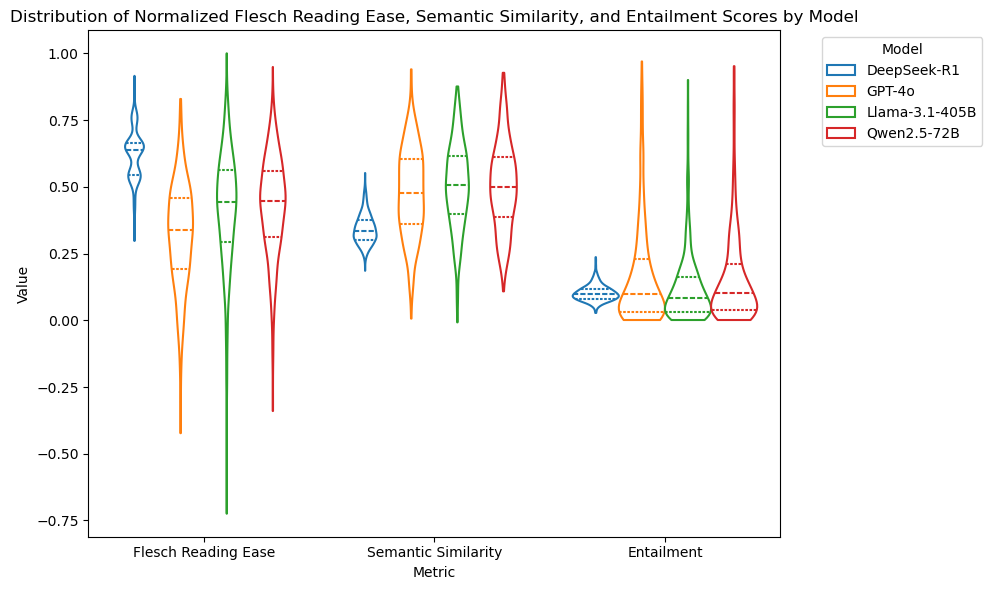

In [5]:
# 3. Create a violin plot.
plt.figure(figsize=(10, 6))
sns.violinplot(data=melted, x='metric', y='value', hue='model', inner="quart", fill=False,
               cut=0)
plt.title('Distribution of Normalized Flesch Reading Ease, Semantic Similarity, and Entailment Scores by Model')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Final Plot

/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_68583/2951732698.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


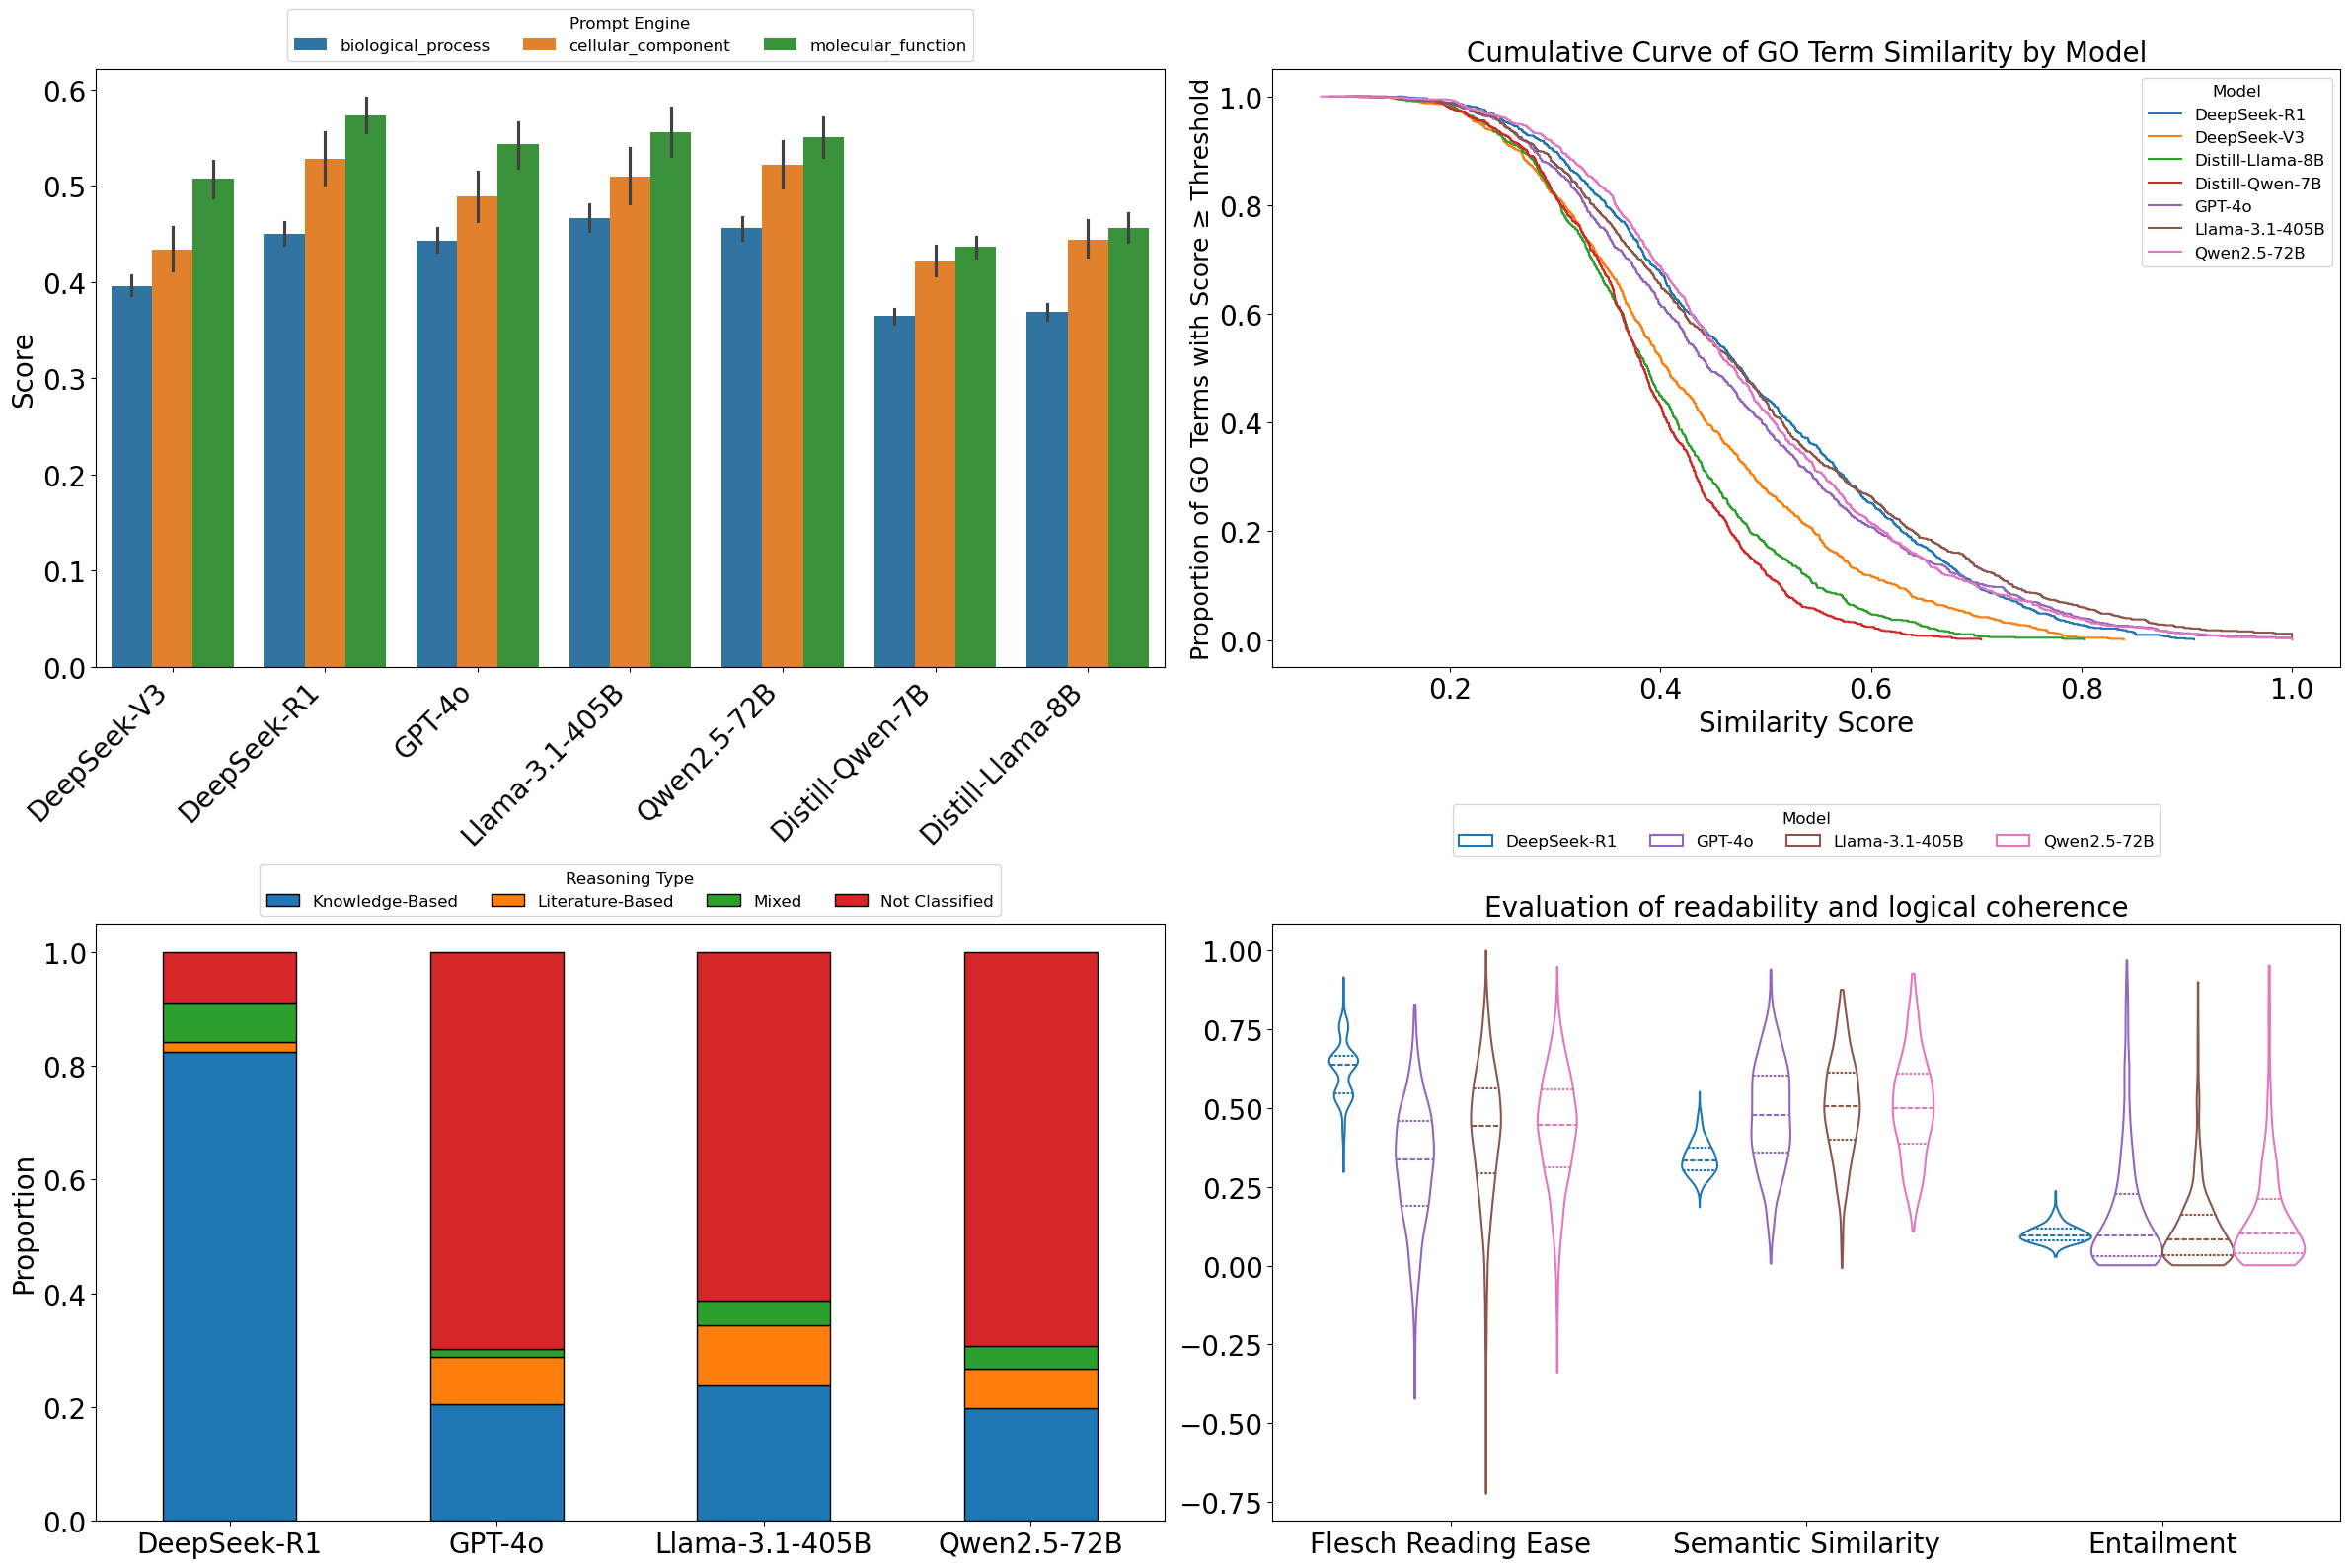

In [20]:
# Create 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))
fig.subplots_adjust(wspace=0.4,  # space between columns
                    hspace=0.6)  # space between rows

# Define a consistent palette for models (using models from acc_df as an example)
models = sorted(res['model'].unique())
palette = sns.color_palette("tab10", n_colors=len(models))
color_map = dict(zip(models, palette))

## Subplot 1: Violin & Strip Plot
ax1.tick_params(axis='both', which='major', labelsize=20)
model_order = sorted(res['model'].unique())
sns.barplot(
    data=res,
    x="model",
    y="score",
    hue="GO_Namespace",
    estimator=np.mean,
    errorbar=("ci", 95), ax=ax1
)
ax1.set_ylabel('Score', fontsize=20)
ax1.set_xlabel("")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='Prompt Engine', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=5, fontsize=12, title_fontsize=12)

## Subplot 2: Heatmap
ax2.tick_params(axis='both', which='major', labelsize=20)
# Loop over each unique model and plot its cumulative curve
for model in models:
    # Filter for the current model
    subset = res[res['model'] == model]
    # Sort the similarity scores
    scores = np.sort(subset['score'].values)
    n = len(scores)
    # For each threshold, compute the proportion of GO Terms with a score ≥ threshold
    proportions_GO = (n - np.arange(n)) / n
    # Plot the step curve with the designated color
    ax2.step(scores, proportions_GO, where="post", label=model, color=color_map[model])
ax2.set_title('Cumulative Curve of GO Term Similarity by Model', fontsize=20)
ax2.set_xlabel("Similarity Score", fontsize=20)
ax2.set_ylabel("Proportion of GO Terms with Score ≥ Threshold", fontsize=18)
ax2.legend(title="Model", bbox_to_anchor=(1, 1), loc='upper right', fontsize=12, title_fontsize=12)

## Subplot 3: Barplot with consistent colors
ax3.tick_params(axis='both', which='major', labelsize=20)
proportions.plot(kind='bar', stacked=True, edgecolor='black', ax=ax3)
#ax3 = proportions.plot(kind='bar', stacked=True, edgecolor='black')
ax3.set_ylabel('Proportion', fontsize=20)
ax3.set_xlabel('')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend(title='Reasoning Type', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=5, fontsize=12, title_fontsize=12)

## Subplot 4: Regression lines with consistent colors
ax4.tick_params(axis='both', which='major', labelsize=20)
sns.violinplot(data=melted, x='metric', y='value', hue='model', inner="quart", fill=False,
               cut=0, ax=ax4, palette=color_map)
ax4.set_title('Evaluation of readability and logical coherence', fontsize=20)
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.legend(title="Model", bbox_to_anchor=(0.5, 1.1), loc='lower center', ncol=5, fontsize=12, title_fontsize=12)


plt.tight_layout()
#plt.savefig('/Users/linxy29/Documents/Files/other collaboration/benchmark/f2_GOTerm.pdf')
plt.show()